## Crack segmentation on asphalt photos- DL

### Maria Musial 156062
### Martyna Stasiak 156071

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


## Loading data
We are reading paths and extracting binary information about existence of cracks from mask photos. 

In [2]:
np.random.seed(44)  #A imie jego czterdziesci i cztery...
tf.random.set_seed(44)

df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./train/images"
masks_directory = "./train/masks"
images = []
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    df.loc[len(df)] = [img_path, label]
labels = np.array(labels)

#SPLITTING DATA FOR VALIDATION AND TRAINING
train_df, val_df = train_test_split(df, test_size=0.2, random_state=44, stratify=df["label"])

-----------
## Data augumentation
**Rescale**- We rescale the image to values <0,1> <br>
**Shear range**- shear transfomation to simulate distortions <br>
**Zoom_range**- randomly zooms image 80% to 120% of its original size. for more variation<br>
**Rotation range-** rotation of image up to 1 degree. As we dont have only perfectly horizontal/vertical lines<br>
**Width shift range**- shifts the image horizontally by a fraction of its width<br>
**Horizontal flip**- true: randomly flips the image horizontally <br>
**Fill mode**- reflect to mirror edge pixels of the image to fill faps<br>
<br><br>
All those settings give simillar images and enough variety to have well augumented data.


No data augumentation for validation, as we need to validate data, but we need rescaling to <0,1>. 

In [3]:
# Define the data generator for augumentation

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.01,      
    zoom_range=(0.8, 1.2),  
    rotation_range=5,   
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 0.9),
    fill_mode='reflect'
)

#Load images from dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,  
    x_col = "filepath",
    y_col = "label",
    target_size=(128, 128),  
    class_mode="binary",  
    batch_size=16,
    shuffle=True,
    seed=44
)

#Defining dynamic creation of validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = "filepath",
    y_col = "label",
    target_size = (128, 128),
    batch_size = 16,
    class_mode = 'binary'
)
validation_steps = len(val_generator)

Found 7682 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.


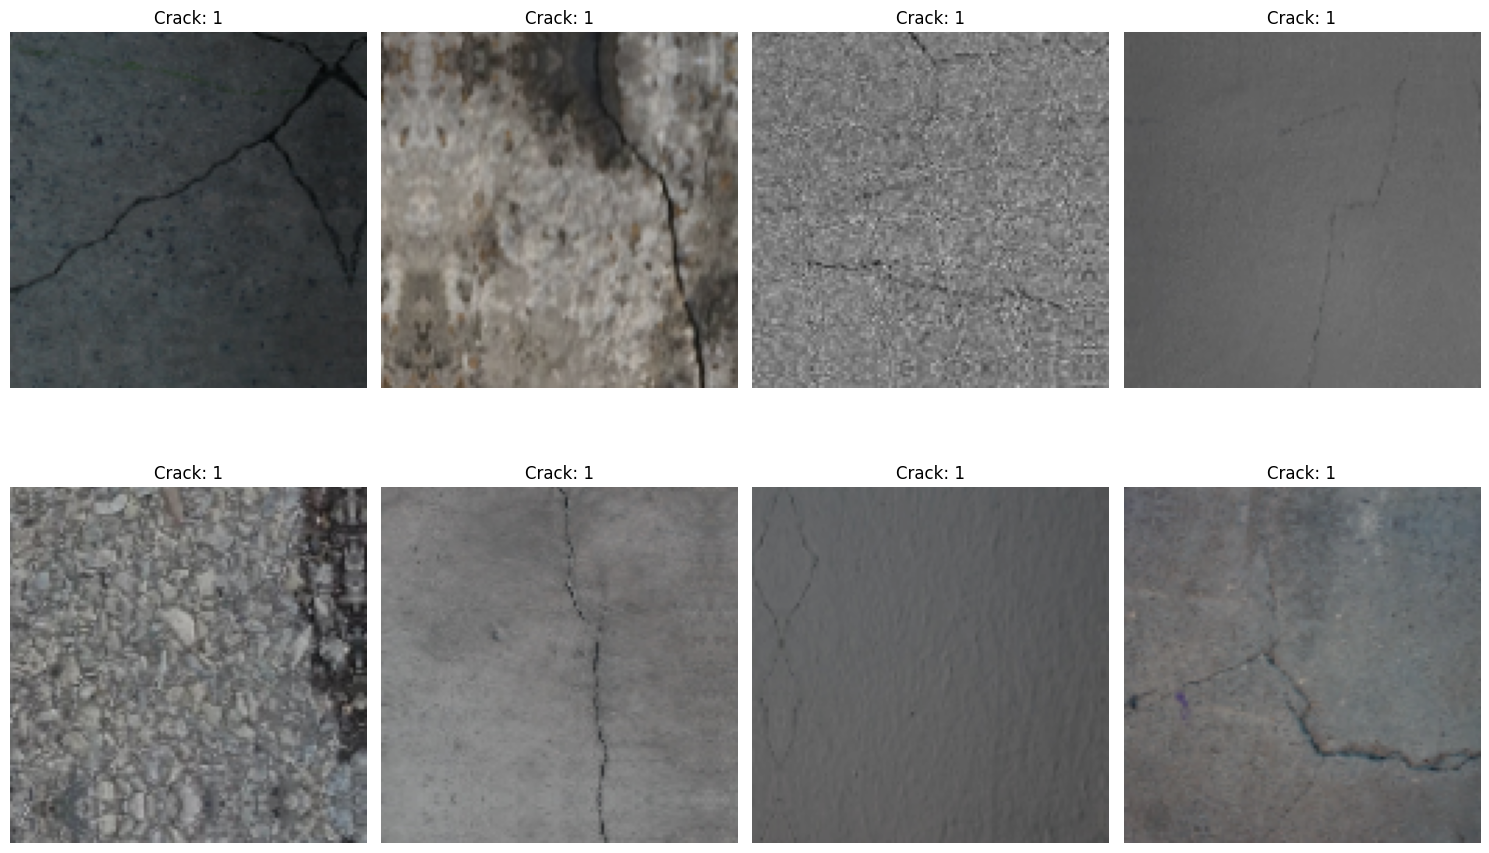

In [4]:
# Function to plot augmented images
def plot_augmented_images(generator, n_rows=2, n_cols=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    # Generate one batch of images and labels
    images, labels = next(generator)  

    # Iterate through the images and display them
    for i in range(len(axs)):
        if i < len(images):  # Ensure we don't go out of bounds
            img = images[i]
            img = (img * 255).astype(np.uint8)

            axs[i].imshow(img)
            axs[i].set_title(f"Crack: {int(labels[i])}")  # Convert label to int
            axs[i].axis('off')
        else:
            axs[i].axis('off')  

    plt.tight_layout()
    plt.show()

# Plot the augmented images
plot_augmented_images(train_generator)

---------
## Models - architecture selection

### We are using keras_tuner to check for best architecture.

##### Get data for hyperparameter tuning. Only a subset for efficiency

In [12]:
# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)  # Load and resize image
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

# Load the DataFrame
df_hyper = val_df.copy()

# Apply preprocessing to all images in the dataframe
df_hyper['image'] = df_hyper['filepath'].apply(load_and_preprocess_image)
X_val = np.array(df_hyper['image'].tolist())
y_val = df_hyper['label'].values.astype(int)

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Input((128, 128, 3)))
    # Input Layer
    model.add(
        Conv2D(
            filters=hp.Choice('filters_layer_0', values=[16, 32, 64]),
            kernel_size=(3, 3),
            activation='relu'
        )
    )
    model.add(MaxPooling2D((2, 2)))

    # Dynamically Adding Convolutional Layers
    for i in range(hp.Int('num_layers', min_value=2, max_value=5)):
        model.add(
            Conv2D(
                filters=hp.Choice(f'filters_layer_{i}', values=[16, 32, 64]),
                kernel_size=(3, 3),
                activation='relu',
                padding='same'
            )
        )
        model.add(MaxPooling2D((2, 2)))

        # Optional Batch Normalization
        if hp.Boolean(f'batch_norm_layer_{i}'):
            model.add(BatchNormalization())

    # Flatten for Dense Layers
    model.add(Flatten())

    # Dense Layers
    model.add(
        Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        )
    )

    # Optional Dropout
    if hp.Boolean('use_dropout'):
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the Model
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
        # metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=20,
    executions_per_trial=1,
    objective="val_accuracy",
    # max_epochs=20,
    # factor=3,  # Determines the reduction factor for successive trials in Hyperband. A higher factor reduces the number of trials but increases the focus on promising configurations.
    directory="tuning",
    project_name="hyperband_tuning"
)

Reloading Tuner from tuning\hyperband_tuning\tuner0.json


In [15]:
#not used, possibly more efficient
# tuner = kt.Hyperband(
#     build_model,
#     objective="val_accuracy",
#     max_epochs=20,
#     factor=3,  # Determines the reduction factor for successive trials in Hyperband. A higher factor reduces the number of trials but increases the focus on promising configurations.
#     directory="tuning",
#     project_name="hyperband_tuning",
# )

In [16]:
tuner.search_space_summary()


Search space summary
Default search space size: 9
filters_layer_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
batch_norm_layer_0 (Boolean)
{'default': False, 'conditions': []}
filters_layer_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
batch_norm_layer_1 (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
use_dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


We are using only validation data, so we're using only subset of data to determine best architecture. Its more computationally efficient, but tells us what we need to know about architectures

In [17]:
tuner.search(X_val, y_val, validation_split=0.2, epochs=10) 

Trial 20 Complete [00h 01m 12s]
val_accuracy: 0.9454545378684998

Best val_accuracy So Far: 0.948051929473877
Total elapsed time: 01h 06m 21s


In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best filters for layer 0: {best_hps.get('filters_layer_0')}")
print(f"Best filters for other layers: {[best_hps.get(f'filters_layer_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best batch normalization: {[best_hps.get(f'batch_norm_layer_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Use dropout: {best_hps.get('use_dropout')}")
if best_hps.get('use_dropout'):
    print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best number of layers: 5
Best filters for layer 0: 16
Best filters for other layers: [16, 32, 32, 16, 16]
Best batch normalization: [False, True, False, False, False]
Best dense units: 96
Use dropout: False
Best learning rate: 0.001


### Building and train the best model


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
)
best_model.summary()


callbacks = [
    ModelCheckpoint('best_model_hyperparametered.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  # Logs for TensorBoard
]
history = best_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks, verbose=1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 63, 63, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 31, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 3, 3, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,457 (99.44 KB)

 Trainable params: 25,393 (99.19 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.8780 - auc: 0.7907 - loss: 0.3180 - precision: 0.9007 - recall: 0.9609 - val_accuracy: 0.8714 - val_auc: 0.4807 - val_loss: 0.9205 - val_precision: 0.8714 - val_recall: 1.0000
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - accuracy: 0.9207 - auc: 0.8923 - loss: 0.2225 - precision: 0.9416 - recall: 0.9695 - val_accuracy: 0.9115 - val_auc: 0.8947 - val_loss: 0.2585 - val_precision: 0.9547 - val_recall: 0.9432
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9378 - auc: 0.9170 - loss: 0.1908 - precision: 0.9501 - recall: 0.9805 - val_accuracy: 0.9204 - val_auc: 0.9202 - val_loss: 0.2152 - val_precision: 0.9568 - val_recall: 0.9516
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step - accuracy: 0.9429 - auc: 0.9248 - loss: 0.1769 - precision: 0.9508 - recall: 0.9856 - val_accuracy: 0.9328 - val_auc: 0.9240 - val_loss: 0.1981 - val_precision: 0.9612 - val_recall: 0.9618
Epoch 5/50
481/481 ━

In [ ]:
def plot_history(hist):
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

## Evlauating the chosen architecture


In [26]:
test_df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./test/images"
masks_directory = "./test/masks"
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    test_df.loc[len(test_df)] = [img_path, label]
labels = np.array(labels)

In [27]:
#Defining new generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Keep order for reproducibility
)

Found 1695 validated image filenames belonging to 2 classes.


In [28]:
best_model.metrics

[<Mean name=loss>, <CompileMetrics name=compile_metrics>]

In [29]:
# Evaluate the model
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

C:\Users\mary9\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9572 - loss: 0.1165


ValueError: not enough values to unpack (expected 5, got 2)

## Result analysis

In [65]:
##check what is wronlgy classified in test
## check the hypothesis that texture of asphalt classifuies cracks, not the cracks alone
## what if we have cracks in concrete
## 


## Pixel importance